In [1]:
#importing necessary libraries
from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [14]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [16]:
censusTracts.shape

(869, 63)

In [3]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [4]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [5]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [6]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [7]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [8]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        idf.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [9]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid',5)

In [10]:
branchInfo

BRANCH                                  LOCATION  \
0                Albany Park   (41.97557881655979, -87.71361314512697)   
1                    Altgeld   (41.65719847558056, -87.59883829075173)   
2             Archer Heights   (41.80110836194246, -87.72648385568911)   
3                     Austin    (41.88917312206642, -87.7658203582574)   
4              Austin-Irving   (41.95312267684315, -87.77928489355646)   
..                       ...                                       ...   
77              West Pullman    (41.67790647382097, -87.6431683153105)   
78                 West Town   (41.89594730478282, -87.66829305460979)   
79     Whitney M. Young, Jr.    (41.7510184591363, -87.61495065361933)   
80  Woodson Regional Library  (41.720694885749005, -87.64304817213312)   
81        Wrightwood-Ashburn   (41.73795704970435, -87.70221598421591)   

                                             geometry   LATITUDE  LONGITUDE  \
0   POLYGON ((-87.71361 41.99322, -87.71461 41.992...  41.975579 -87.713613   
1   POLYGON ((-87.59684 41.69523, -87.59691 41.693...  41.657198 -87.598838   
2   POLYGON ((-87.72348 41.81848, -87.72559 41.816...  41.801108 -87.726484   
3   POLYGON ((-87.76482 41.90631, -87.76582 41.906...  41.889173 -87.765820   
4   POLYGON ((-87.78829 41.96819, -87.78833 41.962...  41.953123 -87.779285   
..                                                ...        ...        ...   
77  POLYGON ((-87.64217 41.70308, -87.64351 41.701...  41.677906 -87.643168   
78  POLYGON ((-87.66729 41.91073, -87.66881 41.909...  41.895947 -87.668293   
79  POLYGON ((-87.63095 41.78607, -87.63108 41.779...  41.751018 -87.614951   
80  POLYGON ((-87.64305 41.74373, -87.64405 41.744...  41.720695 -87.643048   
81  POLYGON ((-87.70222 41.76083, -87.70287 41.755...  41.737957 -87.702216   

                                         list of dict  
0   [{17031140800: 0.10910496440467443, 1703116050...  
1   [{17031825801: 0.1615035489776389, 17031826401...  
2   [{17031650200: 0.0254912176417698, 17031650100...  
3   [{17031252101: 0.39452842303857544, 1703181300...  
4   [{17031190402: 0.022557937206714188, 170311904...  
..                                                ...  
77  [{17031821402: 0.990325261989984, 17031821200:...  
78  [{17031280100: 0.001197490335336308, 170318381...  
79  [{17031490200: 0.006124736067597431, 170314409...  
80  [{17031750500: 0.002029252118561393, 170317506...  
81  [{17031720100: 0.07141694264282171, 1703171130...  

[82 rows x 6 columns]

In [11]:
censusTracts.sort_values(by = 'score', ascending = False)

geoid                              qualifying name  \
322  17031340600     Census Tract 3406, Cook County, Illinois   
323  17031351500     Census Tract 3515, Cook County, Illinois   
320  17031380600     Census Tract 3806, Cook County, Illinois   
377  17031832900     Census Tract 8329, Cook County, Illinois   
348  17031340500     Census Tract 3405, Cook County, Illinois   
..           ...                                          ...   
816  17031980000     Census Tract 9800, Cook County, Illinois   
817  17031770500     Census Tract 7705, Cook County, Illinois   
818  17031770602  Census Tract 7706.02, Cook County, Illinois   
820  17031807600     Census Tract 8076, Cook County, Illinois   
868  17031990000     Census Tract 9900, Cook County, Illinois   

                                              geometry     score          Area  
322  POLYGON ((-87.63625 41.83088, -87.63623 41.830...  3.656036  4.965761e+05  
323  POLYGON ((-87.62907 41.82742, -87.62904 41.827...  3.561942  1.662212e+05  
320  POLYGON ((-87.62931 41.82368, -87.62928 41.823...  3.425128  8.388936e+05  
377  POLYGON ((-87.66666 41.87635, -87.66657 41.876...  3.159490  4.045824e+05  
348  POLYGON ((-87.63637 41.83453, -87.63634 41.834...  3.147072  4.354491e+05  
..                                                 ...       ...           ...  
816  MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...  0.000000  1.902470e+07  
817  MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...  0.000000  1.799139e+05  
818  POLYGON ((-87.90416 42.00363, -87.90424 42.003...  0.000000  6.839449e+05  
820  POLYGON ((-87.70867 42.01896, -87.70867 42.018...  0.000000  1.930083e+04  
868  MULTIPOLYGON (((-87.60911 41.88827, -87.60546 ...  0.000000  4.590237e+03  

[869 rows x 5 columns]

Text(0.5, 1.0, 'Percent of Coverage')

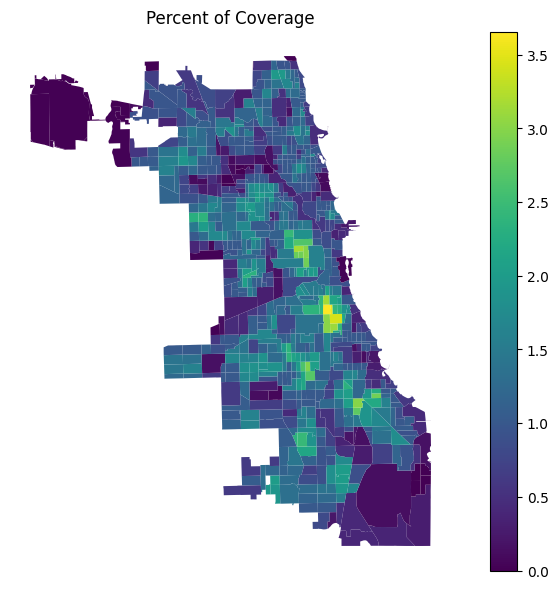

In [12]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [13]:
censusTracts['score'].mean()

1.0938034206665086